# Creating a Synthetic Video Dataset Variant


This notebook demonstrates how to define a new synthetic video dataset using the `Factor`, `FactorSpace`, `StateMapper`, and `VideoGenerator` components from the Multi-factor Sequential Disentanglement (MSD) benchmark.

We will walk through:
1. Loading and wrapping the `dSprites` dataset.
2. Defining static and dynamic latent factors.
3. Creating synthetic videos using interpretable factor combinations.
4. Saving the generated dataset to an HDF5 file.


## Step 1: Load and Wrap the dSprites Dataset

To begin, download the original static dSprites dataset from the official [DeepMind GitHub repository](https://github.com/google-deepmind/dsprites-dataset). The dataset contains grayscale 2D images of shapes (squares, ellipses, hearts) varying along interpretable latent factors such as shape, scale, orientation, position X/Y.

In this tutorial, we use a wrapper class called `dSpritesColored`, which adds color overlays to the original grayscale images using a pre-defined list of named colors. This is useful for increasing visual variability while maintaining full control over the latent structure.

The `dSpritesColored` class is a concrete implementation of the `StateMapper` interface, which only requires three components:
- A list of `Factor` objects defining the labeled latent space,
- An array of data points (e.g., images),
- A corresponding array of labels (with one label per data point, expressed as factor indices).

Users can implement custom `StateMapper` subclasses for any other dataset or rendering logic, as long as it supports retrieval via `__getitem__(factor_dict)`.



In [1]:
import sys
sys.path.append('./research/MSD-Benchmark')

import numpy as np
from msd.data.datasets.dsprites import dSpritesColored
from msd.data.visualization import plot_sequence, plot_image

# Path to the dSprites dataset (.npz format)
dsprites_file = "path/to/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"

# Load the dataset with color augmentation
mapper = dSpritesColored(dsprites_file)
print("Available factors:", mapper.factors.names)


Available factors: ['color', 'shape', 'scale', 'orientation', 'posX', 'posY']


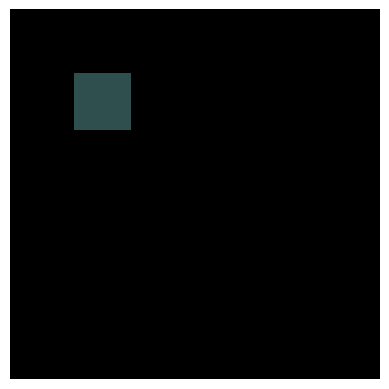

(3, 64, 64) uint8


In [2]:
x = mapper[{'color': 0, 'shape': 0, 'scale': 0, 'orientation': 0, 'posX': 0, 'posY': 0}]
plot_image(x)
print(x.shape, x.dtype)

## Step 2: Define Static Factors


We'll choose a subset of factors to remain fixed throughout the video. 
For positions (posX/posY), we subsample to reduce the total number of combinations.


In [3]:

from msd.data.datasets.synthetic_video_generation.factor_space import FactorSpace

factors = mapper.factors

static_factors = FactorSpace([
    factors['color'][:],
    factors['shape'][:],
    factors['posX'][2::4],
    factors['posY'][2::4],
])
static_factors


FactorSpace(StaticFactor(name=color, values={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}, type=static)
StaticFactor(name=shape, values={0: 0, 1: 1, 2: 2}, type=static)
StaticFactor(name=posX, values={0: 2, 1: 6, 2: 10, 3: 14, 4: 18, 5: 22, 6: 26, 7: 30}, type=static)
StaticFactor(name=posY, values={0: 2, 1: 6, 2: 10, 3: 14, 4: 18, 5: 22, 6: 26, 7: 30}, type=static))

## Step 3: Define Dynamic Factors

Dynamic factors describe how certain attributes evolve over time. In our case, dynamic factors are derived from static factors by applying predefined temporal patterns to their label values.

For example, we can take a static factor like `scale` and define how it should change over a sequence of frames—such as increasing, decreasing, or oscillating. These temporal patterns are expressed using `Sequence` objects, such as:

- `HarmonicSequence`: Loops a sequence forward and then backward in a mirrored pattern. For example, `[0, 1, 2]` becomes `[0, 1, 2, 1, 0, 1, ...]`, and repeats.
- `CyclicSequence`: Repeats the given sequence in a fixed cycle. For example, `[0, 1, 2]` becomes `[0, 1, 2, 0, 1, 2, ...]`.

This allows us to build richly varying video data with interpretable and controllable motion or transformation over time.


In [4]:

from msd.data.datasets.synthetic_video_generation.factor import HarmonicSequence, CyclicSequence

n_scale = len(factors['scale'])
n_orient = len(factors['orientation'])

dynamic_factors = FactorSpace([
    factors['scale'].to_dynamic({
        'increasing_1x': HarmonicSequence(np.arange(0, n_scale, 1)),
        'decreasing_1x': HarmonicSequence(np.arange(n_scale-1, -1, -1)),
        'increasing_2x': HarmonicSequence(np.arange(0, n_scale, 2)),
        'decreasing_2x': HarmonicSequence(np.arange(n_scale-1, -1, -2)),
    }),
    factors['orientation'].to_dynamic({
        'counterclockwise': CyclicSequence(np.arange(0, n_orient, 2)),
        'static': CyclicSequence([0]),
        'clockwise': CyclicSequence(np.roll(np.arange(0, n_orient, 2)[::-1], 1)),
    })
])
dynamic_factors


FactorSpace(DynamicFactor(name=scale_dynamic, values={0: 'increasing_1x', 1: 'decreasing_1x', 2: 'increasing_2x', 3: 'decreasing_2x'}, type=dynamic, dynamics=(Sequence([0 1 2 3 4 5 4 3 2 1]), Sequence([5 4 3 2 1 0 1 2 3 4]), Sequence([0 2 4 2]), Sequence([5 3 1 3])))
DynamicFactor(name=orientation_dynamic, values={0: 'counterclockwise', 1: 'static', 2: 'clockwise'}, type=dynamic, dynamics=(Sequence([ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38]), Sequence([0]), Sequence([ 0 38 36 34 32 30 28 26 24 22 20 18 16 14 12 10  8  6  4  2]))))

## Step 4: Initialize the Video Generator

To generate sequences of images over time, we use the `VideoGenerator` class. It constructs a synthetic video dataset by iterating over all combinations of static and dynamic factor labels.

To initialize it, we provide:

- **`state_mapper`** – An instance of `StateMapper` (in our case, `dSpritesColored`) which maps factor configurations to the corresponding image.
- **`static_factors`** – A `FactorSpace` object specifying which factors remain constant during each sequence.
- **`dynamic_factors`** – A `FactorSpace` object that defines how certain factors change over time via temporal sequences.
- **`T`** – The number of frames per video sequence.

The generator traverses the full Cartesian product of static and dynamic factor labels to produce a dataset of interpretable, temporally varying videos.


In [5]:

from msd.data.datasets.synthetic_video_generation.video_generator import VideoGenerator

T = 16  # number of frames per sequence
generator = VideoGenerator(
    state_mapper=mapper,
    static_factors=static_factors,
    dynamic_factors=dynamic_factors,
    T=T
)

print("Total number of sequences:", len(generator))


Total number of sequences: 20736


## Step 5: Visualize a Generated Video


Let's render a single synthetic sequence and display it frame by frame.


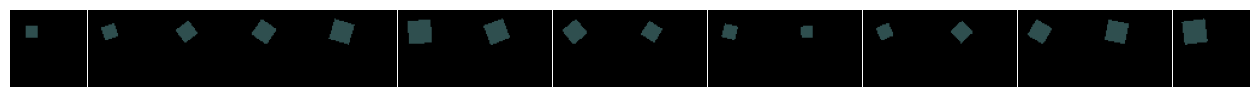

(16, 3, 64, 64) uint8


In [6]:
video = generator[0]
plot_sequence(video)
print(video.shape, video.dtype)


## Step 6: Save the Full Dataset


Finally, we save the full set of generated sequences, including metadata, labels, and splits.


In [8]:
out_path = "/path/to/synthetic_dsprites_variant.h5"
generator.create_dataset(out_path)

20736it [00:49, 419.12it/s]


Dataset saved to synthetic_dsprites_variant.h5


## Step 7: Load and Visualize the Generated Dataset

Now that we have saved our synthetic dSprites dataset to disk, we can load it using the MSD interface.

We'll use the `Hdf5Reader` and `DisentanglementDataset` classes to load the `.h5` file, retrieve a sample, decode its label values as strings, and visualize the generated sequence.

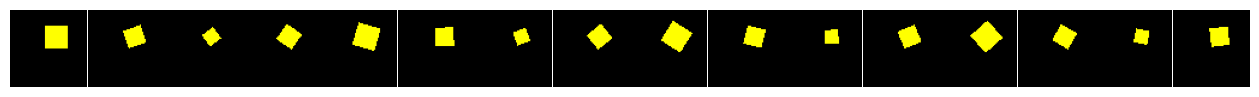

Static Factors: {'color': 'Yellow', 'shape': 'square', 'posX': '0.70968', 'posY': '0.19355'}
Dynamic Factors: {'scale_dynamic': 'decreasing_2x', 'orientation_dynamic': 'counterclockwise'}


In [10]:
# Load necessary components
from msd.data.readers.h5_reader import Hdf5Reader
from msd.data.disentanglement_dataset import DisentanglementDataset
from msd.data.visualization import plot_sequence

# Load the dataset
h5_path = out_path  # update if saved elsewhere
reader = Hdf5Reader(h5_path, split="val")
dataset = DisentanglementDataset(reader, supervised=True, return_names=True)

# Get a sample and plot it
x, ys, yd = dataset[1000]
plot_sequence(x)
print("Static Factors:", ys)
print("Dynamic Factors:", yd)